Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

#from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input
3

3

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/colabdata/CNN_assignment.zip

Archive:  gdrive/MyDrive/colabdata/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflatin

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
!ls 'Skin cancer ISIC The International Skin Imaging Collaboration'/Train

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
SEED=123
np.random.seed(SEED)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, image_size=(img_height,img_width), subset="training", seed=SEED)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:


## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, image_size=(img_width,img_width), subset="validation",seed=SEED)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
path_list_orginal = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_orginal = [os.path.basename(os.path.dirname(x)) for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_o = dict(zip(path_list_orginal, lesion_list_orginal))
original_df = pd.DataFrame(list(dataframe_dict_o.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,nevus
2,Skin cancer ISIC The International Skin Imagin...,nevus
3,Skin cancer ISIC The International Skin Imagin...,nevus
4,Skin cancer ISIC The International Skin Imagin...,nevus


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

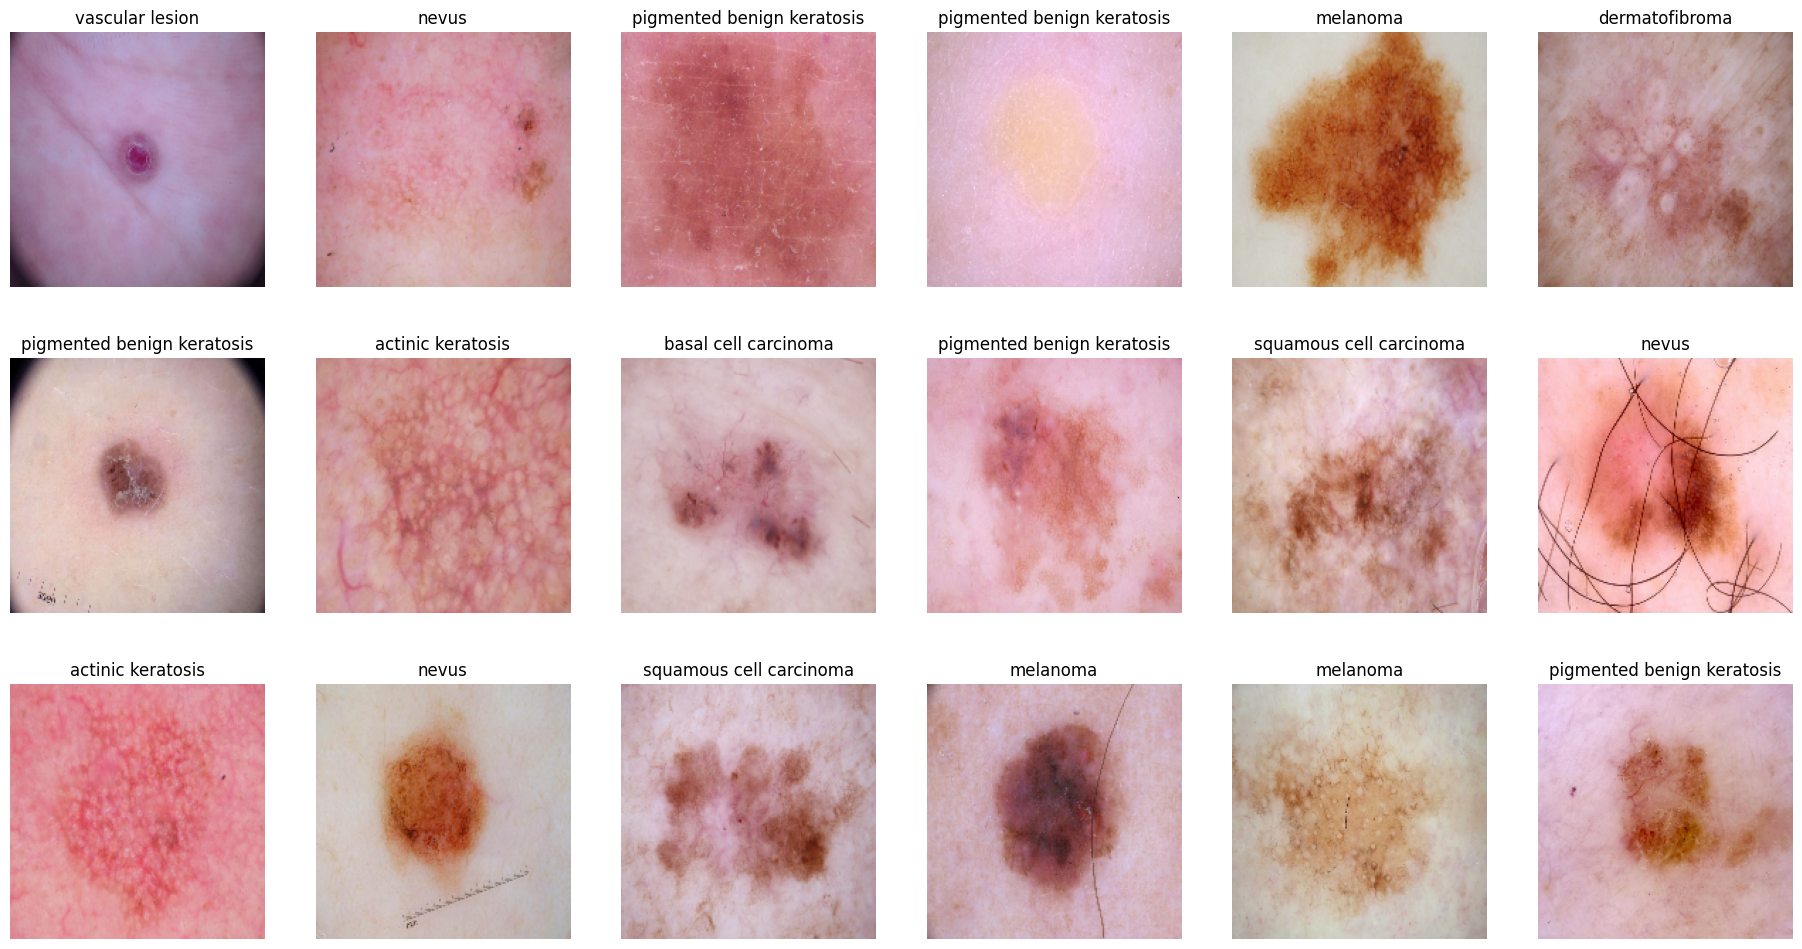

In [ ]:
plt.figure(figsize=(23, 12))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
model = models.Sequential([
    # Input layer with Rescaling to normalize the pixel values
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Rescale layer to normalize RGB values between 0 and 1
    layers.Rescaling(1./255),

    # First convolutional layer with max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional layer with max pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional layer with max pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected dense layer
    layers.Dense(128, activation='relu'),

    # Output layer with 9 units for the 9 classes
    layers.Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 218ms/step - accuracy: 0.2324 - loss: 2.0820 - val_accuracy: 0.4430 - val_loss: 1.6169
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.4176 - loss: 1.6200 - val_accuracy: 0.3512 - val_loss: 1.8718
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4439 - loss: 1.6090 - val_accuracy: 0.5078 - val_loss: 1.4296
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5304 - loss: 1.3451 - val_accuracy: 0.5257 - val_loss: 1.3705
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5432 - loss: 1.2615 - val_accuracy: 0.5436 - val_loss: 1.4031
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5627 - loss: 1.2061 - val_accuracy: 0.5213 - val_loss: 1.3967
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5710 - loss: 1.1841 - val_accuracy: 0.5347 - val_loss: 1.3414
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6230 - loss: 1.0855 - val_accuracy: 0.4832 

### Visualizing training results

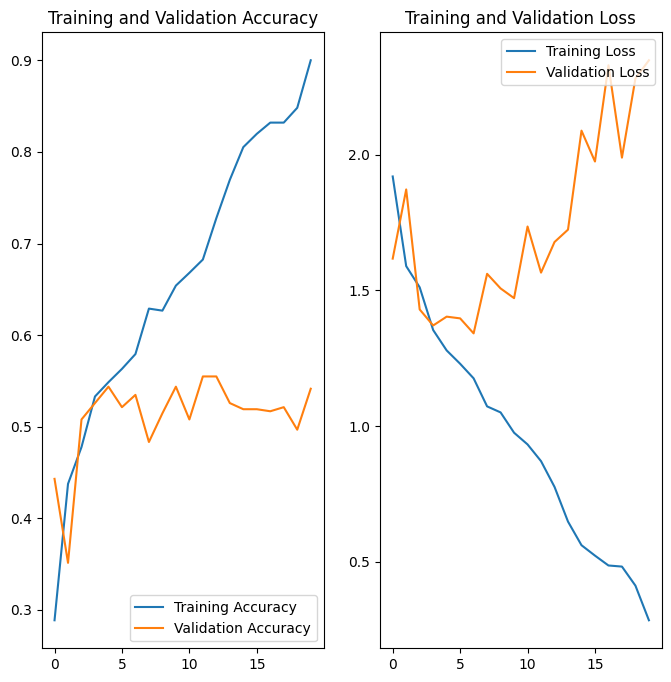

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Signs of Overfitting:
Training Accuracy: The training accuracy steadily increases and reaches a very high value (close to 1.0), which indicates that the model is learning the training data very well.

Validation Accuracy: The validation accuracy increases initially but then plateaus and fluctuates without significant improvement, while the training accuracy continues to improve. This divergence suggests that the model is starting to memorize the training data instead of generalizing to unseen data.

Training Loss: The training loss consistently decreases, indicating that the model is optimizing well on the training set.

Validation Loss: The validation loss decreases initially but then starts to increase while the training loss continues to decrease. This increase in validation loss while training loss decreases is a clear sign of overfitting.

The model is overfitting. It performs well on the training data but fails to generalize to the validation data, as indicated by the plateauing and fluctuating validation accuracy and the increasing validation loss.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Data Augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])



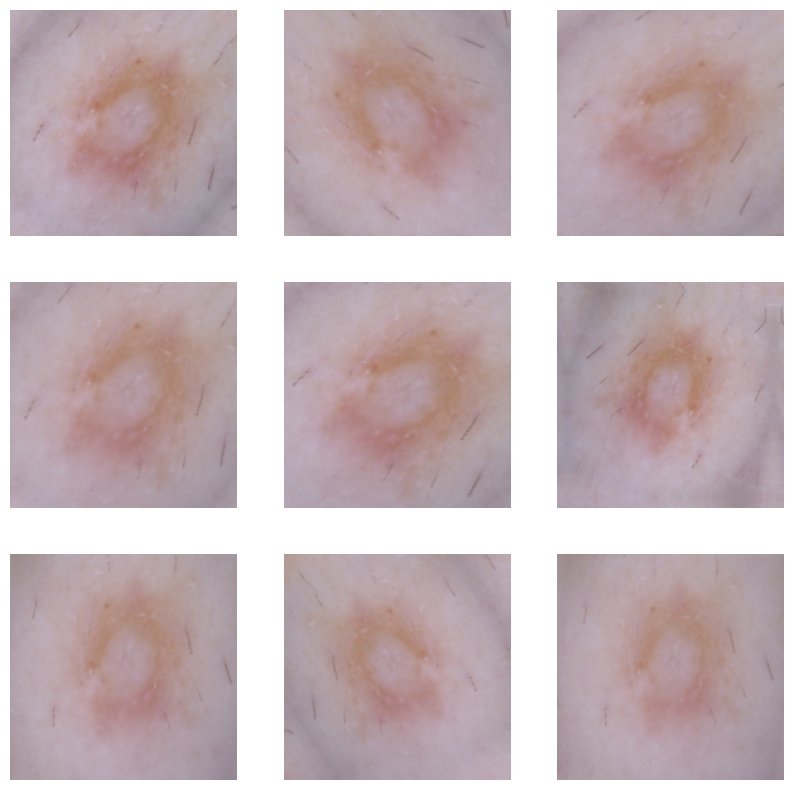

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Load a single image
image_batch, label_batch = next(iter(train_ds))
single_image = image_batch[0]  # Take the first image from the batch

# Reshape the single image to add the batch dimension
single_image = tf.expand_dims(single_image, axis=0)

# Apply the data augmentation multiple times to the same image
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 augmented images
    augmented_image = data_augmentation(single_image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = models.Sequential([
    # Input layer with Rescaling to normalize the pixel values
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Data Augmentation Layer
    data_augmentation,

    # Rescale layer to normalize RGB values between 0 and 1
    layers.Rescaling(1./255),

    # First convolutional layer with max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Apply Dropout after the first pooling layer
    layers.Dropout(0.25),

    # Second convolutional layer with max pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Apply Dropout after the second pooling layer
    layers.Dropout(0.25),

    # Third convolutional layer with max pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Apply Dropout after the third pooling layer
    layers.Dropout(0.25),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected dense layer
    layers.Dense(128, activation='relu'),

    # Apply Dropout after the dense layer
    layers.Dropout(0.5),

    # Output layer with 9 units for the 9 classes
    layers.Dense(9, activation='softmax')
])



### Compiling the model

In [ ]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.1801 - loss: 2.9317 - val_accuracy: 0.1991 - val_loss: 1.9951
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2455 - loss: 2.0006 - val_accuracy: 0.2841 - val_loss: 2.0087
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.2762 - loss: 1.9228 - val_accuracy: 0.3378 - val_loss: 1.8337
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3197 - loss: 1.8591 - val_accuracy: 0.4139 - val_loss: 1.7418
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3859 - loss: 1.7340 - val_accuracy: 0.4318 - val_loss: 1.6509
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.3824 - loss: 1.7155 - val_accuracy: 0.4161 - val_loss: 1.6558
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.3768 - loss: 1.7224 - val_accuracy: 0.4698 - val_loss: 1.5605
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4295 - loss: 1.6038 - val_accuracy: 0.4541 - v

### Visualizing the results

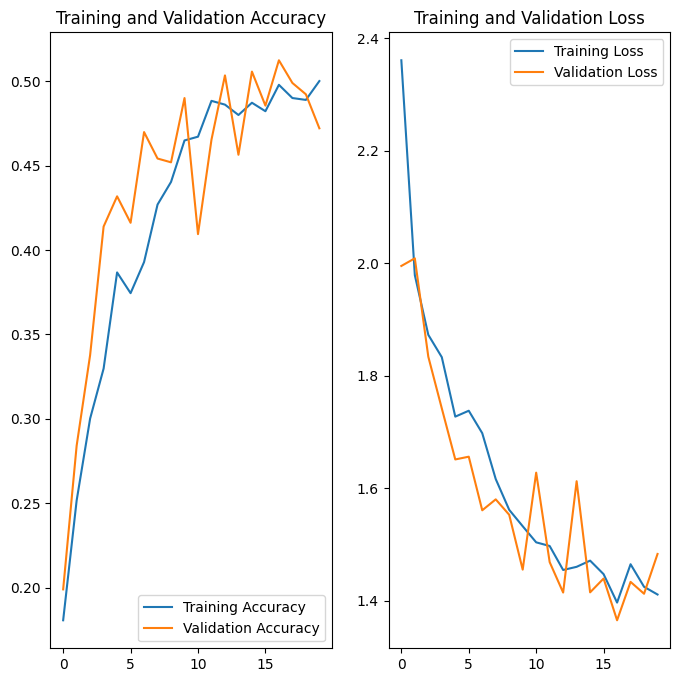

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is no significant sign of overfitting or underfitting in this CNN model. The training and validation curves are closely aligned, suggesting that the model is performing similarly on both the training and validation data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

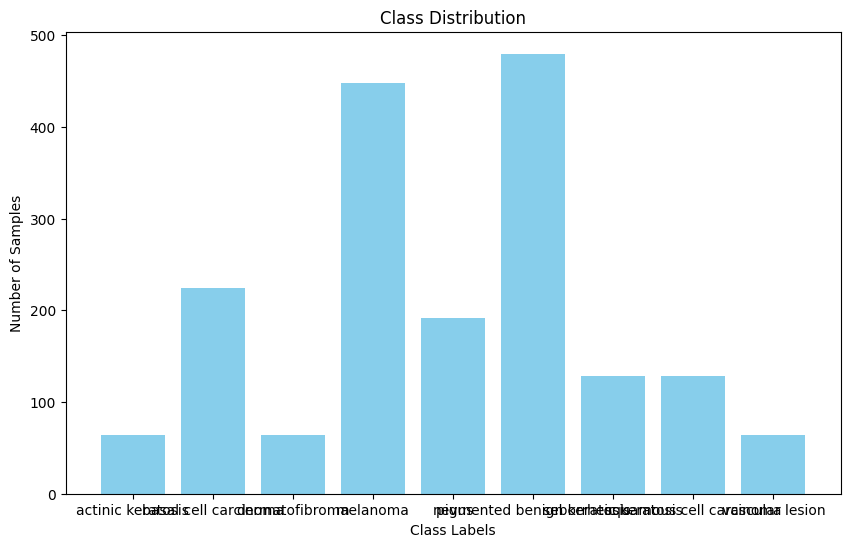

In [ ]:
# Initialize an empty dictionary to store class counts
class_counts = {}

# Iterate over the dataset to count the labels
for images, labels in train_ds:
    labels = labels.numpy()
    for label in labels:
        class_name=class_names[labels[i]]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

# Convert the class_counts dictionary to a sorted list of tuples
class_counts = dict(sorted(class_counts.items()))

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(list(class_counts.keys()))  # Ensure all class labels are shown
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance

> Add blockquote


#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
!ls 'Skin cancer ISIC The International Skin Imaging Collaboration'/Train

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


In [ ]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5840473460>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58403C7AF0>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F57DE730B50>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7F5840438D60>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F585F3F1540>: 100%|██████████| 500/500 [01:13<00:00,  6.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58403C4070>: 100%|██████████| 500/500 [00:15<00:00, 31.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F58403C4100>: 100%|██████████| 500/500 [00:34<00:00, 14.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5840303790>: 100%|██████████| 500/500 [00:14<00:00, 33.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5840427F40>: 100%|██████████| 500/500 [00:15<00:00, 32.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])
new_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,nevus
2,Skin cancer ISIC The International Skin Imagin...,nevus
3,Skin cancer ISIC The International Skin Imagin...,nevus
4,Skin cancer ISIC The International Skin Imagin...,nevus


In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train=data_dir_train #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
from collections import defaultdict

# Initialize a dictionary to hold the counts
image_counts = defaultdict(int)

# Iterate through the dataset and count images in each category
for images, labels in train_ds:
    for label in labels:
        image_counts[label.numpy()] += 1

# Map labels to category names (if needed)
class_names = train_ds.class_names
category_counts = {class_names[label]: count for label, count in image_counts.items()}

# Print out the counts
for category, count in category_counts.items():
    print(f"Category: {category}, Number of Images: {count}")

Category: dermatofibroma, Number of Images: 455
Category: vascular lesion, Number of Images: 493
Category: melanoma, Number of Images: 755
Category: pigmented benign keratosis, Number of Images: 773
Category: nevus, Number of Images: 677
Category: basal cell carcinoma, Number of Images: 721
Category: seborrheic keratosis, Number of Images: 456
Category: squamous cell carcinoma, Number of Images: 569
Category: actinic keratosis, Number of Images: 493


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = models.Sequential([
    # Input layer with Rescaling to normalize the pixel values
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Data Augmentation Layer
    data_augmentation,

    # Rescale layer to normalize RGB values between 0 and 1
    layers.Rescaling(1./255),

    # First convolutional layer with max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Apply Dropout after the first pooling layer
    layers.Dropout(0.25),

    # Second convolutional layer with max pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Apply Dropout after the second pooling layer
    layers.Dropout(0.5),

    # Third convolutional layer with max pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Apply Dropout after the third pooling layer
    layers.Dropout(0.25),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected dense layer
    layers.Dense(128, activation='relu'),

    # Apply Dropout after the dense layer
    layers.Dropout(0.5),

    # Output layer with 9 units for the 9 classes
    layers.Dense(9, activation='softmax')
])



#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.4275 - loss: 1.4286 - val_accuracy: 0.4840 - val_loss: 1.3078
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.4610 - loss: 1.3725 - val_accuracy: 0.4781 - val_loss: 1.2999
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 183ms/step - accuracy: 0.4435 - loss: 1.4183 - val_accuracy: 0.4885 - val_loss: 1.2905
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.4517 - loss: 1.4004 - val_accuracy: 0.4714 - val_loss: 1.3434
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.4455 - loss: 1.4374 - val_accuracy: 0.4907 - val_loss: 1.2845
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - accuracy: 0.4644 - loss: 1.3510 - val_accuracy: 0.4714 - val_loss: 1.4092
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.4467 - loss: 1.3786 - val_accuracy: 0.4915 - val_loss: 1.3218
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.4492 - loss: 1

#### **Todo:**  Visualize the model results

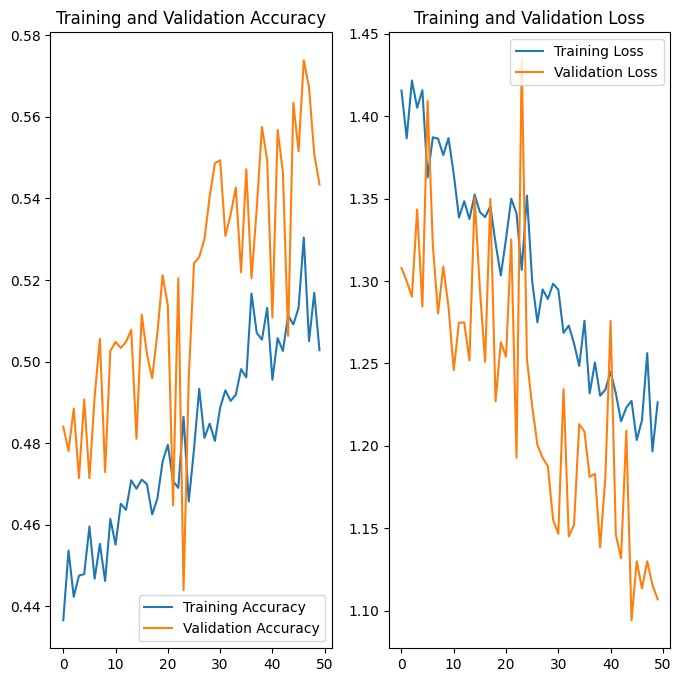

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The class rebalance partially solved the problem.
Increased the dropout value further and also increased the epochs.
The validation score is better then training score and also the validation loss is less then the training loss.